In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [72]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
   

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots(figsize=(14,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.grid(False)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig,ax

# Analysis

In [4]:
# Prepare data
demographic = pd.read_csv('../data/processed/demographic.csv')
severity = pd.read_csv('../data/processed/severity.csv', index_col=0)
features = demographic.columns 
X = demographic.astype(np.float64)
y = (severity >= 4).sum(axis=1)

In [44]:
needs_to_label = {0:'no needs', 1:'low_needs', 2:'moderate needs', 3:'high needs', 4:'very high needs'}
labels = ["no needs", "low needs", "moderate needs", "high needs", "very high needs"]
severity_to_needs = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4}
y = np.array([severity_to_needs[i] for i in y])
# Color vector, for illustration purposes
colors = {0:'b', 1:'r', 2:'g', 3:'c', 4:'y'}
y_c = np.array([colors[i] for i in y])
def color_fn(i):
    color_dict = {0:'g', 1:'m', 2:'red', 3:'y', 4:'#FFA500'}
    return color_dict[i]

### Class Balance

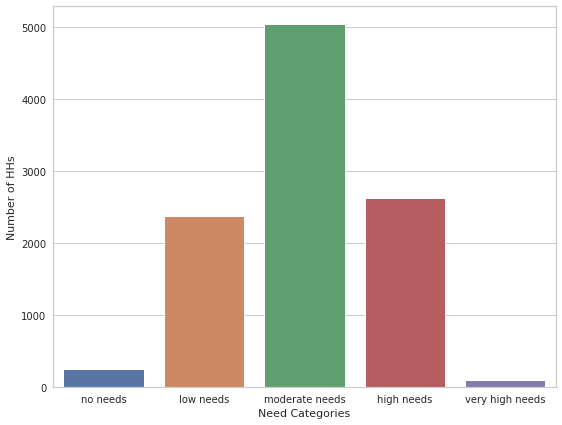

In [7]:
categories, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(figsize=(9, 7))
sb.set(style="whitegrid")
sb.barplot(labels, counts, ax=ax, tick_label=labels)
ax.set(xlabel='Need Categories',
       ylabel='Number of HHs');
fig.savefig('../reports/figures/class_imbalance.png', dpi=300)

Heavy class imbalances. Use appropriate scoring metrics/measures.

## Learning

In [61]:
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [10]:
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

Training target statistics: Counter({2: 4025, 3: 2094, 1: 1900, 0: 202, 4: 81})
Testing target statistics: Counter({2: 1007, 3: 523, 1: 475, 0: 51, 4: 20})


### Random Forests

In [54]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [55]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Balanced accuracy: 0.27, Accuracy: 0.47
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.07      0.02      0.99      0.03      0.14      0.02        51
      low needs       0.40      0.29      0.87      0.33      0.50      0.24       475
 moderate needs       0.52      0.68      0.40      0.58      0.52      0.28      1007
     high needs       0.40      0.31      0.85      0.35      0.51      0.25       523
very high needs       0.25      0.05      1.00      0.08      0.22      0.05        20

    avg / total       0.45      0.47      0.64      0.45      0.50      0.25      2076

Confusion matrix, without normalization


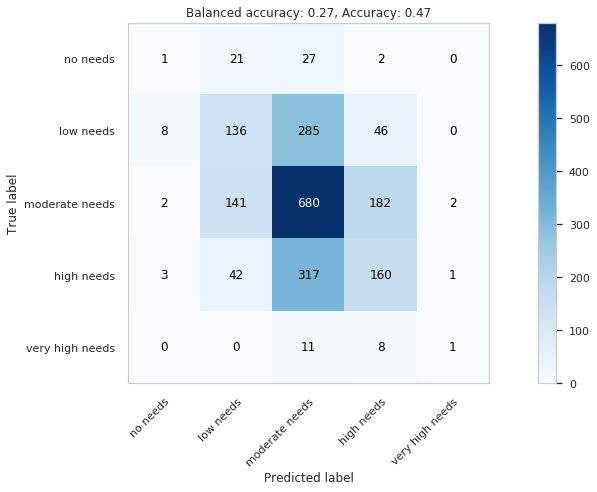

In [73]:
title = 'Balanced accuracy: {:.2f}, Accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred),
                                                         accuracy_score(y_test, y_pred))
print(title)
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred, target_names=labels))
fig, ax = plot_confusion_matrix(y_test, y_pred, classes=labels)
ax.set_title(title)
fig.savefig('../reports/figures/randomforest_cm.png', dpi=300)

In [12]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0, 
                                     n_jobs=-1)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)

Balanced accuracy: 0.39
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.07      0.61      0.81      0.13      0.70      0.48        51
      low needs       0.30      0.26      0.82      0.28      0.46      0.20       475
 moderate needs       0.55      0.19      0.85      0.28      0.40      0.15      1007
     high needs       0.40      0.28      0.86      0.33      0.49      0.22       523
very high needs       0.02      0.60      0.75      0.04      0.67      0.44        20

    avg / total       0.44      0.24      0.84      0.29      0.45      0.19      2076

Confusion matrix, without normalization


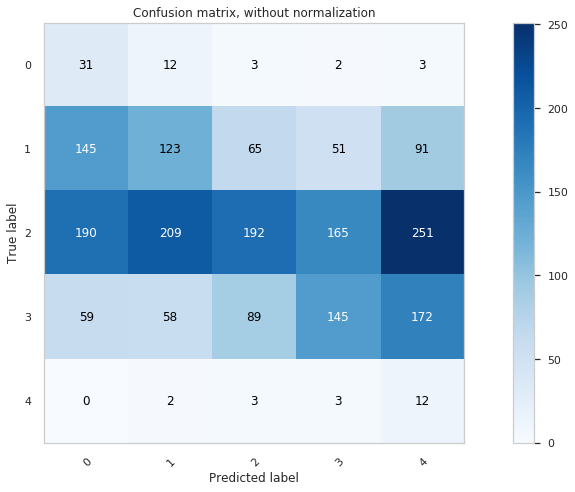

In [16]:
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred_brf)))
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_brf, target_names=labels))
plot_confusion_matrix(y_test, y_pred_brf, classes=np.unique(y_test))

### GridSearchCV

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [18]:
cv_ = StratifiedKFold(10)
clf = BalancedRandomForestClassifier()

In [21]:
param_dist = {"n_estimators": np.arange(50,500,10),
              "max_depth": sp_randint(2,50),
              "max_features": [None, 'sqrt', 0.9, 0.8],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1,11),
             }
scoring_fns = { 'acc': 'balanced_accuracy', 'gm': make_scorer(geometric_mean_score)}
grid = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, cv=cv_, scoring=scoring_fns,
                            n_iter=100, n_jobs=-1, refit='acc', iid=False, 
                            verbose=3)

In [22]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=BalancedRandomForestClassifier(bootstrap=True,
                                                            class_weight=None,
                                                            criterion='gini',
                                                            max_depth=None,
                                                            max_features='auto',
                                                            max_leaf_nodes=None,
                                                            min_impurity_decrease=0.0,
                                                            min_samples_leaf=2,
                                                            min_samples_split=2,
                                                            min_weight_fraction_leaf...
                                        'n_estimators':

Balanced accuracy: 0.41
Classification report: 
                       pre       rec       spe        f1       geo       iba       sup

       no needs       0.08      0.63      0.81      0.14      0.71      0.50        51
      low needs       0.35      0.24      0.87      0.29      0.46      0.20       475
 moderate needs       0.57      0.23      0.84      0.33      0.44      0.18      1007
     high needs       0.42      0.30      0.86      0.35      0.51      0.24       523
very high needs       0.02      0.65      0.74      0.05      0.69      0.48        20

    avg / total       0.47      0.26      0.85      0.32      0.47      0.21      2076

Confusion matrix, without normalization


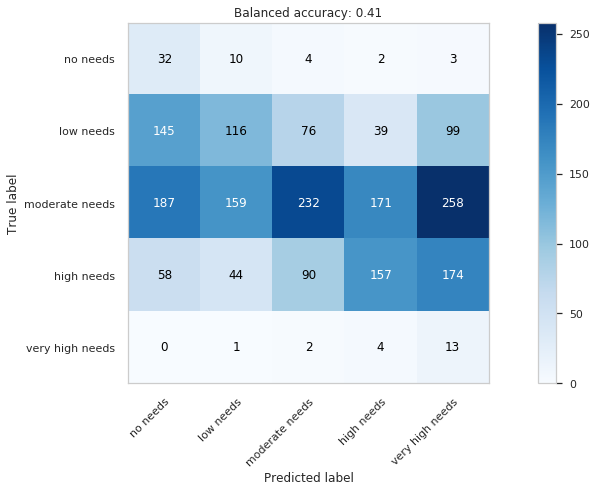

In [74]:
y_pred_grid = grid.predict(X_test)
title = 'Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred_grid))
print(title)
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_grid, target_names=labels))
fig, ax = plot_confusion_matrix(y_test, y_pred_grid, classes=labels)
ax.set_title('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_test,y_pred_grid)))
fig.savefig('../reports/figures/balancedrandomforest_cm.png', dpi=300)

In [29]:
#uncomment if you want to avoid running the randomized parameter search
#params = {'max_depth': 42,
# 'max_features': 0.8,
# 'min_samples_leaf': 3,
# 'min_samples_split': 4,
# 'n_estimators': 460}
#estimator = BalancedRandomForestClassifier(**params)
#estimator.fit(X_train, y_train);
estimator = grid.best_estimator_

## SHAP Analysis

In [30]:
import shap
import warnings
warnings.filterwarnings("ignore")

In [31]:
shap.initjs()

In [33]:
explainer = shap.KernelExplainer(estimator.predict_proba, shap.kmeans(X_train, 5))

In [34]:
shap_values = explainer.shap_values(X_test);

100%|██████████| 2076/2076 [21:11<00:00,  1.67it/s]


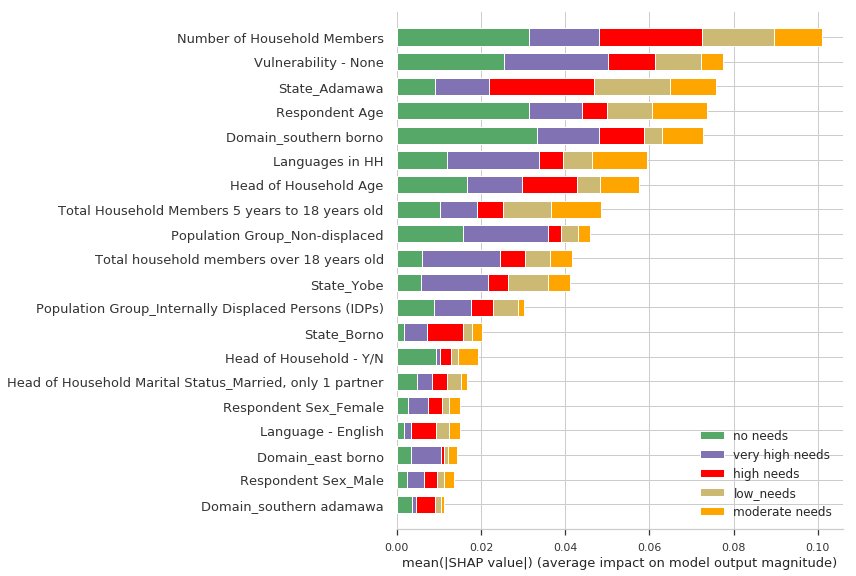

In [48]:
shap.summary_plot(shap_values, X_test, color = color_fn, class_names=needs_to_label)